In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [85]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim import corpora
from textblob import TextBlob
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.sparse import save_npz, load_npz


In [3]:
#set seed so that code output is deterministic
random.seed(0)  # Set the seed for Python's random module
np.random.seed(0)  # Set the seed for NumPy's random module

In [4]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [5]:
data = data.drop(columns = ['index'])
data.head()

text_type       ID  year                                          long_text  \
0   comment  gtfo2hl  2021                       *Cuntry roads, take me hoem*   
1   comment  gtfqkbv  2021  That’s been there for several years, sent a pi...   
2   comment  gtfou07  2021  I am single and I have not traveled to any cun...   
3   comment  gtfrgpe  2021       What happens when you shop at dragon mart...   
4   comment  gthiiwi  2021  That’s just absolutely hilarious, is this in t...   

                                   clean_text  word_count  \
0                           cuntry roads hoem           3   
1  years sent pic cuntry friend long time ago           8   
2            single traveled cuntry past year           5   
3                    happens shop dragon mart           4   
4           absolutely hilarious springs souk           4   

                                              tokens  
0                               [cuntry, road, hoem]  
1  [year, send, pic, cuntry, friend, long, time, ...  
2               [single, travel, cuntry, past, year]  
3                       [happen, shop, dragon, mart]  
4              [absolutely, hilarious, spring, souk]

## **Bag of Words Model** (from Sklearn)

In [6]:
max_df = [1.0, 0.95,0.90, 0.85, 0.80, 0.75,0.5]
min_df = [0.0, 5,10, 20,25,50,100]
cvs = []
doc_vecs = []

#convert df['tokens'] to list of strings for CountVectorizer
corpus = data['tokens'].apply(lambda token: ' '.join(token)).tolist()

for i, (max_sw, min_sw) in enumerate(zip (max_df, min_df)):
    start_time = time.time() #track start time of execution
    #instantiate CountVectorizer
    cv = CountVectorizer(max_df = max_sw, min_df = min_sw)   
   
    #save the instantiated cv objects
    cvs.append(cv)
    
    #generate document vectors 
    X_bow = cv.fit_transform(corpus)
    print (f"The program with {max_sw} max_df and {min_sw} min_df took {time.time() - start_time:.2f} seconds to complete. The ngram representation had { X_bow.shape[1]} features.")
    
    #save the document-term matrices
    save_npz(f'X_bow{i}.npz', X_bow)
    

The program with 1.0 max_df and 0.0 min_df took 1.58 seconds to complete. The ngram representation had 39810 features.
The program with 0.95 max_df and 5 min_df took 1.43 seconds to complete. The ngram representation had 12286 features.
The program with 0.9 max_df and 10 min_df took 1.44 seconds to complete. The ngram representation had 8284 features.
The program with 0.85 max_df and 20 min_df took 1.43 seconds to complete. The ngram representation had 5638 features.
The program with 0.8 max_df and 25 min_df took 1.43 seconds to complete. The ngram representation had 4896 features.
The program with 0.75 max_df and 50 min_df took 1.42 seconds to complete. The ngram representation had 3177 features.
The program with 0.5 max_df and 100 min_df took 1.42 seconds to complete. The ngram representation had 1974 features.


### **FIRST Bag-of-Words MODEL** (max_df = 1.0, min_df = 0.0)

In [7]:
X_bow_0 = load_npz('X_bow0.npz')
print (f'The document-term matrix has {X_bow_0.shape[0]} documents, {X_bow_0.shape[1]} unique words')

The document-term matrix has 99186 documents, 39810 unique words


In [8]:
#get feature names 
bow_features = cvs[0].get_feature_names_out()
bow_features[:100]

array(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaahhhhhhhh',
       'aaaaaaaalso', 'aaaaaaagjhhhhdhwiwhkakwjjsk', 'aaaaaand', 'aaaaah',
       'aaaaand', 'aaaahhh', 'aaaall', 'aaaand', 'aaagess', 'aaah',
       'aaahh', 'aaand', 'aaargh', 'aadaa', 'aadc', 'aadhar', 'aadmi',
       'aage', 'aah', 'aahhh', 'aaj', 'aak', 'aalllmost', 'aam', 'aamer',
       'aamin', 'aams', 'aan', 'aanu', 'aao', 'aap', 'aape', 'aapko',
       'aaraamam', 'aaramam', 'aarbab', 'aarey', 'aarif', 'aaron',
       'aarrgg', 'aas', 'aat', 'aathmaave', 'aaw', 'aawww', 'aaya',
       'aayega', 'ab', 'abaar', 'ababwa', 'aback', 'abacus', 'abandon',
       'abandonment', 'abate', 'abattoir', 'abawa', 'abawu', 'abay',
       'abaya', 'abayas', 'abb', 'abba', 'abbar', 'abbas', 'abbey',
       'abbird', 'abbott', 'abbreviate', 'abbreviation', 'abbreviations',
       'abbvie', 'abc', 'abcd', 'abd', 'abdallah', 'abdefgh', 'abdel',
       'abdilahi', 'abdirahman', 'abdominal', 'abduct', 'abduction',
       'abdul', 

In [9]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_0[8000:8005].toarray(), columns = bow_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   brodsky  buy  car  center  check  city  ...  thing  time  town  trade  uni  \
0        0    0    0       1      0     0  ...      0     0     0      1    0   
1        1    0    0       0      0     1  ...      0     0     1      0    1   
2        0    0    0       0      0     0  ...      0     0     0      0    0   
3        0    0    1       0      1     0  ...      0     1     0      0    0   
4        0    1    0       0      0     0  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 73 columns]

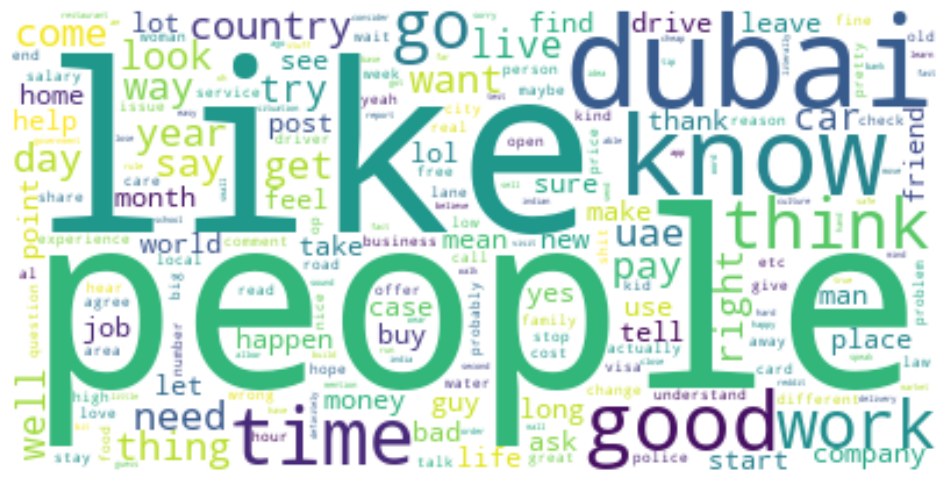

In [10]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(bow_features, X_bow_0.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Document Clustering with KMeans**

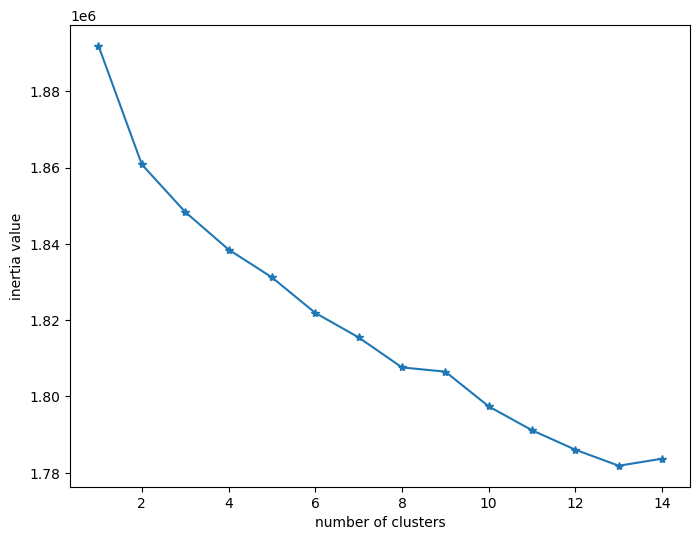

CPU times: user 495 ms, sys: 37 ms, total: 532 ms
Wall time: 235 ms


In [11]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 5000)
    kmeans.fit(X_bow_0)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **SECOND Bag-of-Words MODEL** (max_df = 0.95, min_df = 5)

In [12]:
X_bow_1 = load_npz('X_bow1.npz')
print (f'The document-term matrix has {X_bow_1.shape[0]} documents, {X_bow_1.shape[1]} unique words')

The document-term matrix has 99186 documents, 12286 unique words


In [13]:
#get feature names 
bow1_features = cvs[1].get_feature_names_out()
bow1_features[:100]

array(['aa', 'aaaand', 'aah', 'aaron', 'ab', 'aback', 'abandon', 'abaya',
       'abayas', 'abbreviation', 'abc', 'abcd', 'abdallah', 'abdul',
       'abdulla', 'abdullah', 'abhorrent', 'abide', 'ability', 'abit',
       'able', 'ablution', 'abnormal', 'abnormally', 'abolish',
       'abomination', 'abood', 'aboriginal', 'abortion', 'abra',
       'abraham', 'abrahamic', 'abras', 'abroad', 'abruptly', 'abscond',
       'absence', 'absent', 'absolute', 'absolutely', 'absolve', 'absorb',
       'abstract', 'absurd', 'absurdly', 'abu', 'abudhabi', 'abundance',
       'abundant', 'abuse', 'abuser', 'abusive', 'abwab', 'abysmal', 'ac',
       'academia', 'academic', 'academy', 'acc', 'accelerate',
       'acceleration', 'accelerator', 'accent', 'accents', 'accenture',
       'accept', 'acceptable', 'acceptance', 'access', 'accessibility',
       'accessible', 'accessory', 'accident', 'accidentally',
       'accommodate', 'accommodation', 'accomodation', 'accompany',
       'accomplish', 'ac

In [14]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_1[8000:8005].toarray(), columns = bow1_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   buy  car  center  check  city  covid  ...  thing  time  town  trade  uni  \
0    0    0       1      0     0      0  ...      0     0     0      1    0   
1    0    0       0      0     1      0  ...      0     0     1      0    1   
2    0    0       0      0     0      0  ...      0     0     0      0    0   
3    0    1       0      1     0      0  ...      0     1     0      0    0   
4    1    0       0      0     0      1  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 67 columns]

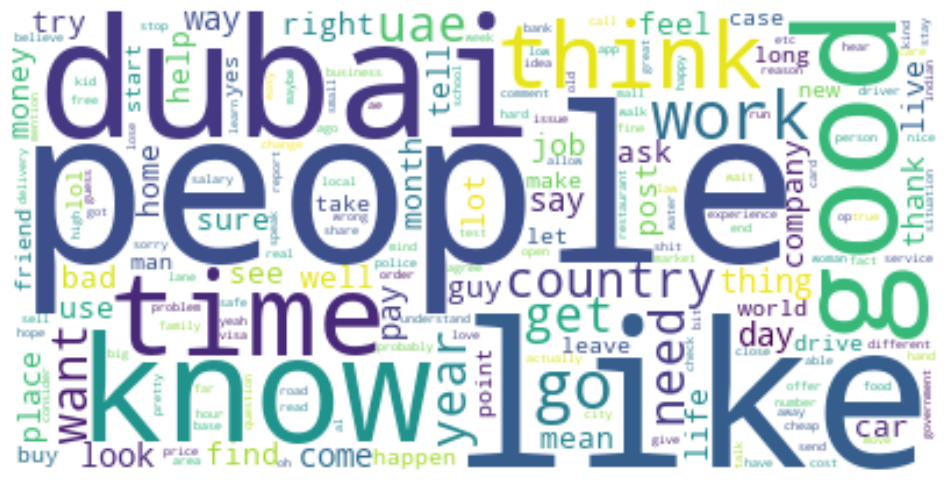

In [15]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores1 = zip(bow1_features, X_bow_1.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores1_dict = dict(word_scores1)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores1_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Document Clustering with KMeans**

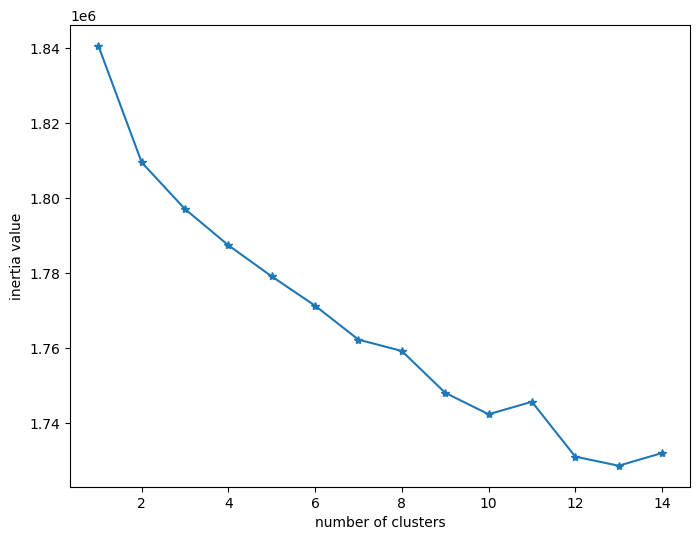

CPU times: user 496 ms, sys: 30.5 ms, total: 527 ms
Wall time: 217 ms


In [16]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow_1)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **THIRD Bag-of-Words MODEL** (max_df = 0.90, min_df = 10)

In [17]:
X_bow_2 = load_npz('X_bow2.npz')
print (f'The document-term matrix has {X_bow_2.shape[0]} documents, {X_bow_2.shape[1]} unique words')

The document-term matrix has 99186 documents, 8284 unique words


In [18]:
#get feature names 
bow2_features = cvs[2].get_feature_names_out()
bow2_features[:100]

array(['aah', 'aback', 'abandon', 'abaya', 'abdullah', 'abide', 'ability',
       'able', 'abolish', 'abomination', 'abood', 'abortion', 'abra',
       'abraham', 'abroad', 'absence', 'absolute', 'absolutely', 'absorb',
       'abstract', 'absurd', 'abu', 'abudhabi', 'abundance', 'abuse',
       'abusive', 'abwab', 'abysmal', 'ac', 'academia', 'academic',
       'academy', 'acc', 'accelerate', 'accent', 'accept', 'acceptable',
       'acceptance', 'access', 'accessible', 'accessory', 'accident',
       'accidentally', 'accommodate', 'accommodation', 'accomodation',
       'accompany', 'accomplish', 'accomplishment', 'accord',
       'accordance', 'accordingly', 'account', 'accountability',
       'accountable', 'accountant', 'accounting', 'accumulate',
       'accuracy', 'accurate', 'accurately', 'accusation', 'accuse',
       'accustomed', 'ace', 'ache', 'achievable', 'achieve',
       'achievement', 'acid', 'acknowledge', 'acquaintance', 'acquire',
       'acquisition', 'act', 'actin

In [19]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_2[8000:8005].toarray(), columns = bow2_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   buy  car  center  check  city  covid  ...  thing  time  town  trade  uni  \
0    0    0       1      0     0      0  ...      0     0     0      1    0   
1    0    0       0      0     1      0  ...      0     0     1      0    1   
2    0    0       0      0     0      0  ...      0     0     0      0    0   
3    0    1       0      1     0      0  ...      0     1     0      0    0   
4    1    0       0      0     0      1  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 65 columns]

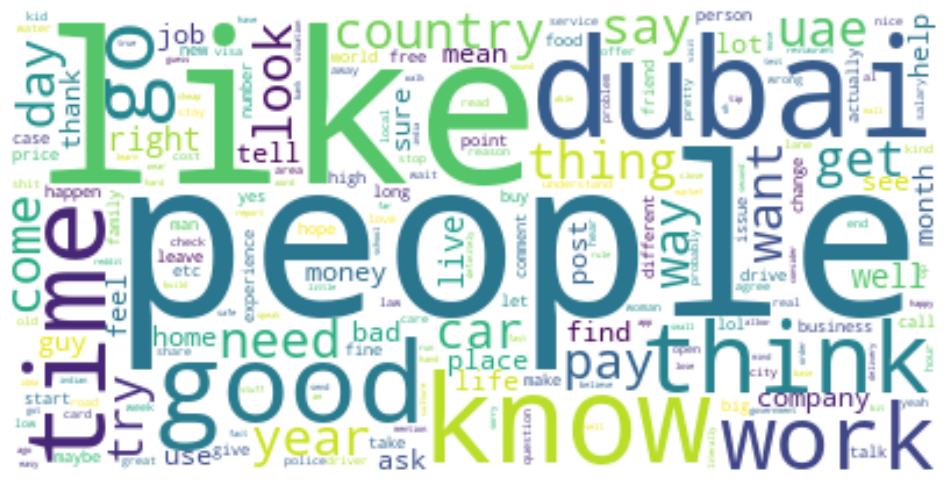

In [20]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores2 = zip(bow2_features, X_bow_2.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores2_dict = dict(word_scores2)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores2_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Document Clustering with KMeans**

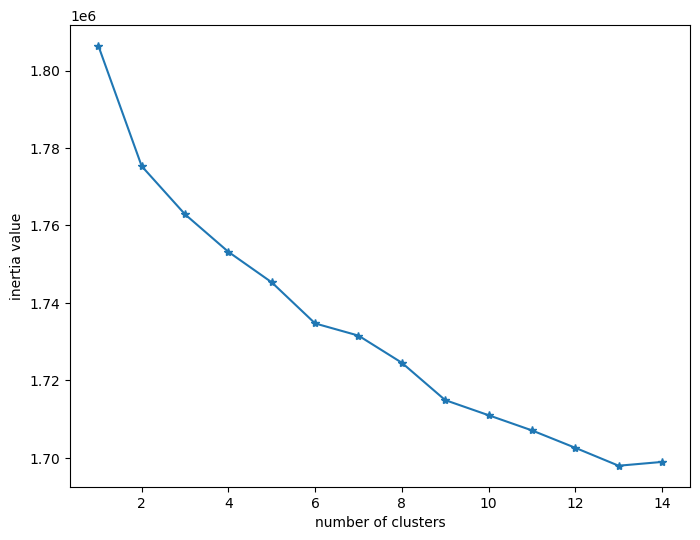

CPU times: user 454 ms, sys: 36.4 ms, total: 490 ms
Wall time: 265 ms


In [21]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow_2)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **FOURTH Bag-of-Words MODEL** (max_df = 0.85, min_df = 20)

In [22]:
X_bow_3 = load_npz('X_bow3.npz')
print (f'The document-term matrix has {X_bow_3.shape[0]} documents, {X_bow_3.shape[1]} unique words')

The document-term matrix has 99186 documents, 5638 unique words


In [23]:
#get feature names 
bow3_features = cvs[3].get_feature_names_out()
bow3_features[:100]

array(['aah', 'abandon', 'abaya', 'abide', 'ability', 'able', 'abra',
       'abroad', 'absence', 'absolute', 'absolutely', 'absorb', 'absurd',
       'abu', 'abudhabi', 'abuse', 'abusive', 'ac', 'academic',
       'accelerate', 'accent', 'accept', 'acceptable', 'acceptance',
       'access', 'accessible', 'accident', 'accidentally', 'accommodate',
       'accommodation', 'accomodation', 'accomplish', 'accord',
       'accordingly', 'account', 'accountable', 'accountant',
       'accounting', 'accumulate', 'accurate', 'accusation', 'accuse',
       'ace', 'achieve', 'achievement', 'acknowledge', 'acquaintance',
       'acquire', 'act', 'action', 'activate', 'active', 'actively',
       'activity', 'actor', 'actual', 'actually', 'ad', 'adapt', 'adcb',
       'add', 'addict', 'addiction', 'addition', 'additional',
       'additionally', 'address', 'adhere', 'adjust', 'admin',
       'administration', 'admire', 'admission', 'admit', 'adnoc', 'adopt',
       'adoption', 'adult', 'advance',

In [24]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_3[8000:8005].toarray(), columns = bow3_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   buy  car  center  check  city  covid  ...  thing  time  town  trade  uni  \
0    0    0       1      0     0      0  ...      0     0     0      1    0   
1    0    0       0      0     1      0  ...      0     0     1      0    1   
2    0    0       0      0     0      0  ...      0     0     0      0    0   
3    0    1       0      1     0      0  ...      0     1     0      0    0   
4    1    0       0      0     0      1  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 60 columns]

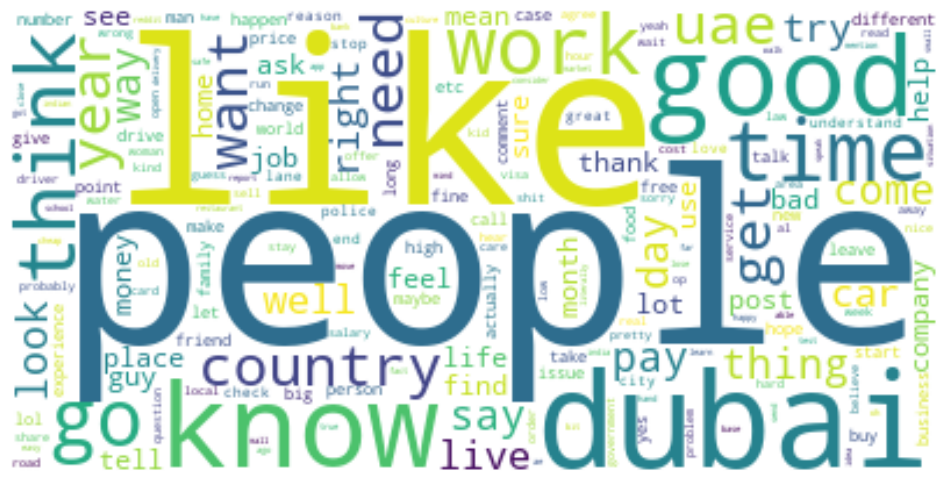

In [25]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores3 = zip(bow3_features, X_bow_3.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores3_dict = dict(word_scores3)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores3_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Document Clustering with KMeans**

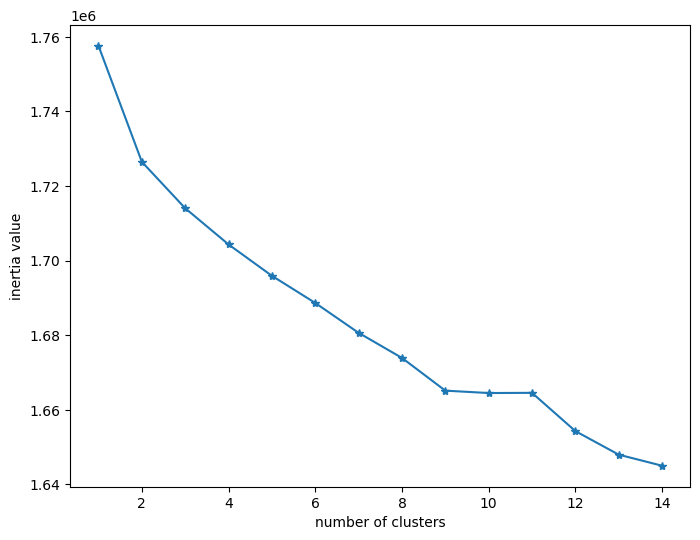

CPU times: user 498 ms, sys: 30.2 ms, total: 528 ms
Wall time: 219 ms


In [26]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow_3)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **FIFTH Bag-of-Words MODEL** (max_df = 0.80, min_df = 25)

In [27]:
X_bow_4 = load_npz('X_bow4.npz')
print (f'The document-term matrix has {X_bow_4.shape[0]} documents, {X_bow_4.shape[1]} unique words')

The document-term matrix has 99186 documents, 4896 unique words


In [28]:
#get feature names 
bow4_features = cvs[4].get_feature_names_out()
bow4_features[:100]

array(['abandon', 'abaya', 'abide', 'ability', 'able', 'abra', 'abroad',
       'absolute', 'absolutely', 'absorb', 'absurd', 'abu', 'abudhabi',
       'abuse', 'abusive', 'ac', 'academic', 'accelerate', 'accent',
       'accept', 'acceptable', 'acceptance', 'access', 'accessible',
       'accident', 'accidentally', 'accommodate', 'accommodation',
       'accomodation', 'accomplish', 'accord', 'accordingly', 'account',
       'accountable', 'accountant', 'accurate', 'accusation', 'accuse',
       'achieve', 'achievement', 'acknowledge', 'acquaintance', 'acquire',
       'act', 'action', 'activate', 'active', 'actively', 'activity',
       'actor', 'actual', 'actually', 'ad', 'adapt', 'adcb', 'add',
       'addict', 'addition', 'additional', 'additionally', 'address',
       'adhere', 'adjust', 'admin', 'admire', 'admit', 'adopt',
       'adoption', 'adult', 'advance', 'advanced', 'advantage',
       'adventure', 'advert', 'advertise', 'advertisement', 'advertising',
       'advice', 'a

In [29]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_4[8000:8005].toarray(), columns = bow4_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   buy  car  center  check  city  covid  ...  thing  time  town  trade  uni  \
0    0    0       1      0     0      0  ...      0     0     0      1    0   
1    0    0       0      0     1      0  ...      0     0     1      0    1   
2    0    0       0      0     0      0  ...      0     0     0      0    0   
3    0    1       0      1     0      0  ...      0     1     0      0    0   
4    1    0       0      0     0      1  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 59 columns]

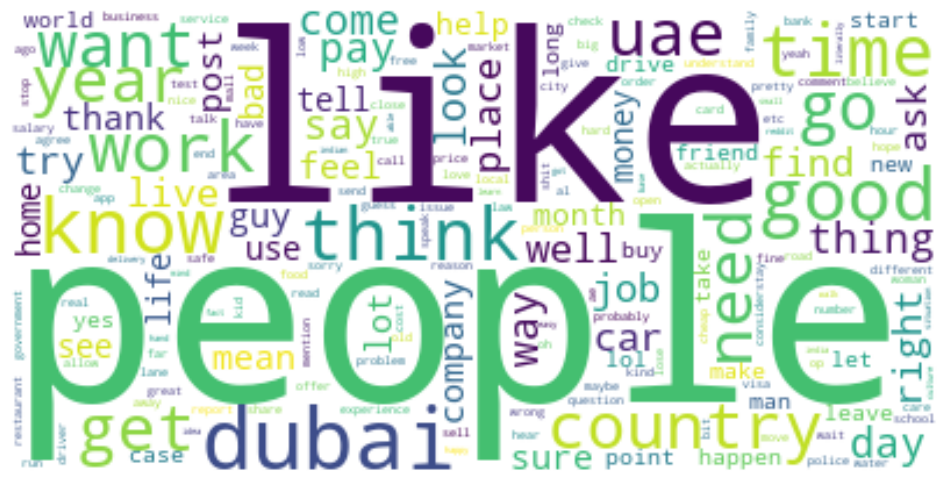

In [30]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores4 = zip(bow4_features, X_bow_4.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores4_dict = dict(word_scores4)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores4_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Document Clustering with KMeans**

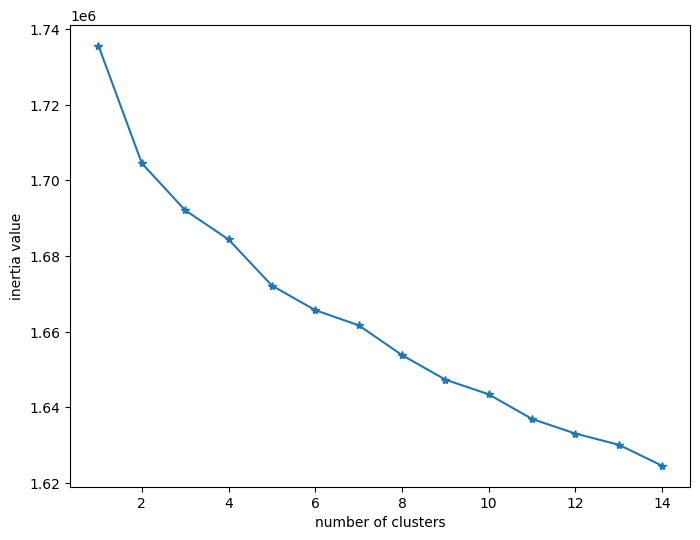

CPU times: user 502 ms, sys: 32.6 ms, total: 534 ms
Wall time: 221 ms


In [31]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow_4)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **SIXTH Bag-of-Words MODEL** (max_df = 0.75, min_df = 50)

In [32]:
X_bow_5 = load_npz('X_bow5.npz')
print (f'The document-term matrix has {X_bow_5.shape[0]} documents, {X_bow_5.shape[1]} unique words')

The document-term matrix has 99186 documents, 3177 unique words


In [33]:
#get feature names 
bow5_features = cvs[5].get_feature_names_out()
bow5_features[:100]

array(['abandon', 'abide', 'ability', 'able', 'abroad', 'absolute',
       'absolutely', 'abu', 'abudhabi', 'abuse', 'ac', 'accent', 'accept',
       'acceptable', 'access', 'accessible', 'accident', 'accommodate',
       'accommodation', 'accord', 'accordingly', 'account', 'accurate',
       'accuse', 'achieve', 'achievement', 'acknowledge', 'acquire',
       'act', 'action', 'activate', 'active', 'actively', 'activity',
       'actual', 'actually', 'ad', 'adapt', 'adcb', 'add', 'addition',
       'additional', 'address', 'adjust', 'admin', 'admit', 'adopt',
       'adult', 'advance', 'advanced', 'advantage', 'adventure',
       'advertise', 'advertising', 'advice', 'advise', 'advocate', 'ae',
       'aed', 'af', 'afaik', 'affair', 'affect', 'afford', 'affordable',
       'afraid', 'africa', 'african', 'africans', 'afternoon', 'age',
       'agency', 'agenda', 'agent', 'aggregator', 'aggressive', 'ago',
       'agree', 'agreement', 'ah', 'ahead', 'ahh', 'ai', 'aid', 'aim',
       'ain

In [34]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_5[8000:8005].toarray(), columns = bow5_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   buy  car  center  check  city  covid  ...  thing  time  town  trade  uni  \
0    0    0       1      0     0      0  ...      0     0     0      1    0   
1    0    0       0      0     1      0  ...      0     0     1      0    1   
2    0    0       0      0     0      0  ...      0     0     0      0    0   
3    0    1       0      1     0      0  ...      0     1     0      0    0   
4    1    0       0      0     0      1  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 56 columns]

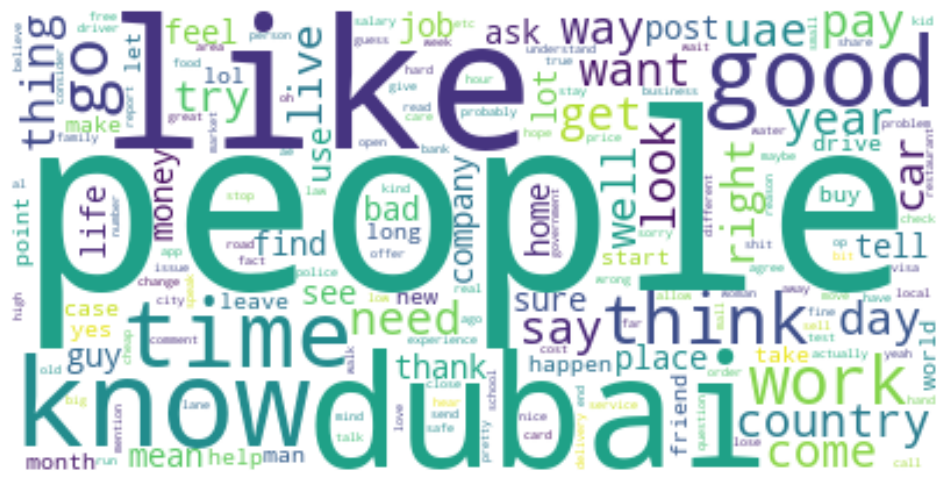

In [35]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores5 = zip(bow5_features, X_bow_5.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores5_dict = dict(word_scores5)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores5_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **Document Clustering with KMeans**

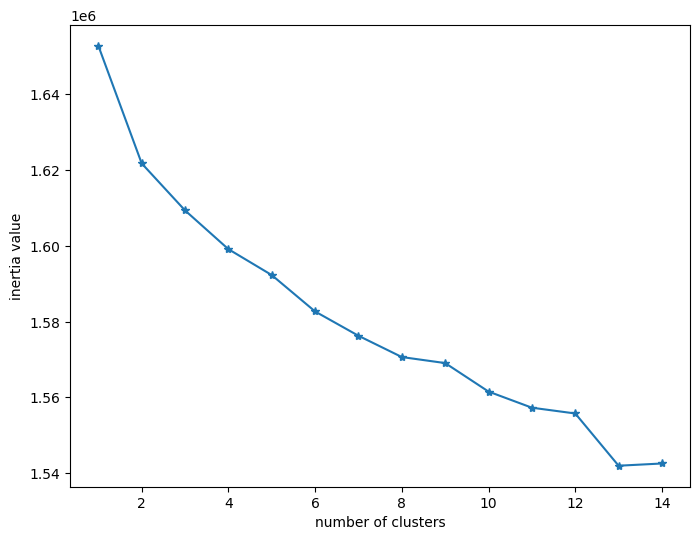

CPU times: user 497 ms, sys: 33.2 ms, total: 530 ms
Wall time: 224 ms


In [36]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow_5)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **SEVENTH Bag-of-Words MODEL** (max_df = 0.5, min_df = 100)

In [37]:
X_bow_6 = load_npz('X_bow6.npz')
print (f'The document-term matrix has {X_bow_6.shape[0]} documents, {X_bow_6.shape[1]} unique words')

The document-term matrix has 99186 documents, 1974 unique words


In [38]:
#get feature names 
bow6_features = cvs[6].get_feature_names_out()
bow6_features[:100]

array(['ability', 'able', 'abroad', 'absolute', 'absolutely', 'abu',
       'abuse', 'ac', 'accent', 'accept', 'acceptable', 'access',
       'accident', 'accommodation', 'accord', 'account', 'accurate',
       'accuse', 'achieve', 'act', 'action', 'active', 'activity',
       'actual', 'actually', 'ad', 'add', 'additional', 'address',
       'admit', 'adopt', 'adult', 'advance', 'advantage', 'advertise',
       'advertising', 'advice', 'advise', 'ae', 'aed', 'af', 'affect',
       'afford', 'affordable', 'afraid', 'africa', 'african', 'age',
       'agency', 'agenda', 'agent', 'aggressive', 'ago', 'agree',
       'agreement', 'ah', 'ahead', 'aim', 'ain', 'air', 'airline',
       'airport', 'ajman', 'al', 'alcohol', 'ali', 'allah', 'allow',
       'alot', 'alright', 'alternative', 'amazing', 'amazon', 'america',
       'american', 'americans', 'angry', 'animal', 'announce', 'annoy',
       'annoying', 'annual', 'answer', 'anti', 'anybody', 'anymore',
       'anytime', 'anyways', 'apart

In [39]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow_6[8000:8005].toarray(), columns = bow6_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   buy  car  center  check  city  covid  ...  thing  time  town  trade  uni  \
0    0    0       1      0     0      0  ...      0     0     0      1    0   
1    0    0       0      0     1      0  ...      0     0     1      0    1   
2    0    0       0      0     0      0  ...      0     0     0      0    0   
3    0    1       0      1     0      0  ...      0     1     0      0    0   
4    1    0       0      0     0      1  ...      1     1     0      0    0   

   village  visit  want  world  year  
0        0      0     0      1     0  
1        0      0     0      0     0  
2        0      1     0      0     0  
3        1      0     1      0     1  
4        0      0     0      0     0  

[5 rows x 55 columns]

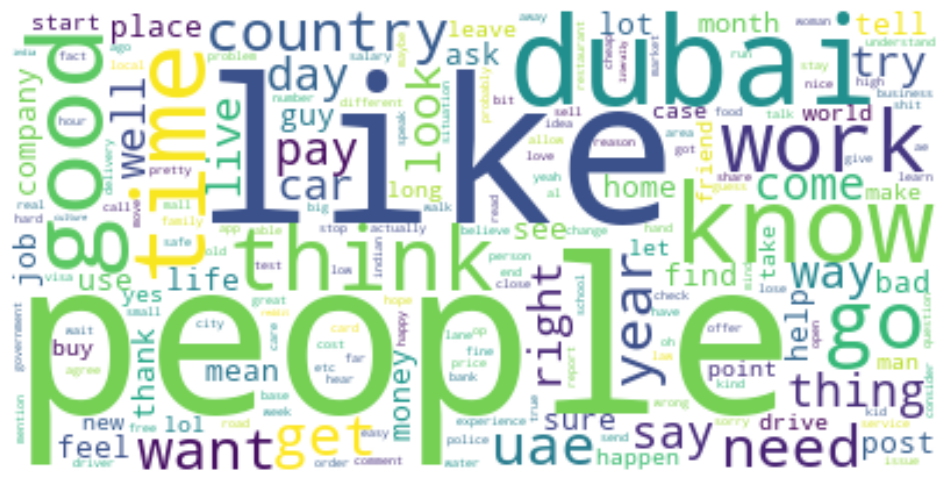

In [45]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores6 = zip(bow6_features, X_bow_6.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores6_dict = dict(word_scores6)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores6_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

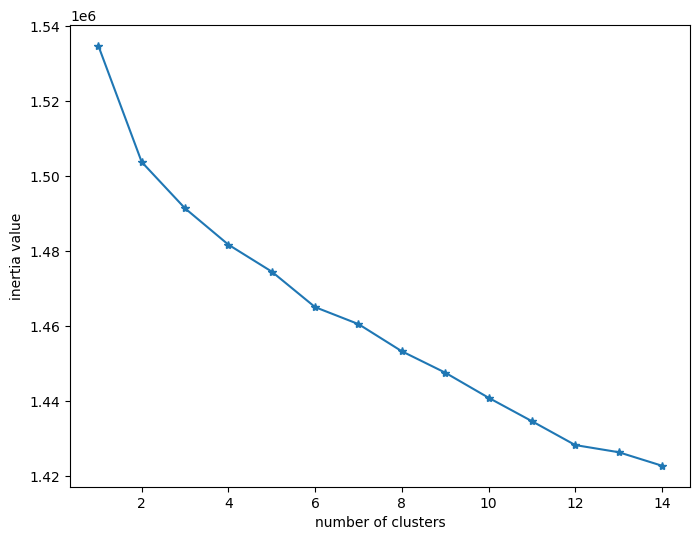

CPU times: user 512 ms, sys: 31.3 ms, total: 544 ms
Wall time: 229 ms


In [41]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,15))

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow_6)
    sse_metric.append(kmeans.inertia_)
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

%time plt.show()
    

### **CREATE CUSTOM STOP WORDS**

In [76]:
#list of all words in the dataframe
all_words = [word for token_row in data['tokens'] for word in token_row]

#frequency of word occurrence
fdist = FreqDist(all_words)


common = [word for word, freq in fdist.items() if freq >=3000]
rare = [word for word, freq in fdist.items() if freq <=10]
other_words = [
    "yeah", "okay", "ok", "lol", "omg", "brb", "btw", "imo", "imho", "ttyl", "idk", 
    "ikr", "smh", "np", "ty", "yw", "jk", "nvm", "tbh", "idc", "ily", "tmi", "wtf", 
    "wyd", "lmk", "atm", "fyi", "gtg", "g2g", "bff", "rofl", "stfu", "asap", 
    "post", "comment", "share", "like", "tweet", "follow", "update", "thread", 
    "dm", "pm", "status", "story", "tag", "meme", "emoji", "gif", "irl", "ama", 
    "tldr", "fomo", "yolo", "nsfw", "tbt", "q&a", "dms", "op", "subs", "mod", 
    "bot", "flair", "downvote", "upvote", "thread", "repost", "sidebar", "sticky", 
    "wiki", "karma", "gold", "throwaway", "username", "redditor", "crosspost", "redditor",
    "vote", "tl", "dr", "wow", "right", "sure", "definitely", "maybe", "know", "lately", 
    "probably", "r", "keep", "ae", "al", "kind", "oh", "wait", "stay", "shit", "old", "guess",
    "damn", "oh", "pretty", "hard", "reddit", "sub", "subreddit", "author", "previous", "got",
    "depend", "old", "nice", "cld", "pic", "bro", "shot", "photo", "oh", "question", "wish", "remember",
    "idea", "stuff", "fuck", "word", "second", "first", "third", "wrong", "easy", "week", "true",
    "believe", "literal", "literally", "haha", "hate", "move", "mind", "away", "yes", "big", 
    "problem", "happy", "high", "quality", "rate", "woman", "sorry", "happen", "feel", "guy", 
    "life", "try", "thank", "lot", "appreciate", "great", "help", "info", "information", "try",
    "bad", "feel", "world", "make", "lose", "love", "join", "place", "friend", "ask", "tell",
    "try", "live", "use", "hope", "soon", "let", "month", "talk", "help", "make", "different",
    "start", "issue", "mater", "hear", "leave", "actually", "person", "mention"
    "agree", "new", "though", "thought", "although", "send", "exact", "exactly", "man", "check",
    "number", "sound", "change", "close", "hour", "run", "video", "point", "wear", "wat", "far",
    "phone", "care", "understand", "kid", "dude", "reason", "ago", "speak", "miss", "free",
    "consider", "absolutely", "open", "situation", "edit", "open", "worth", "link", "watch", "video",
    "today", "head", "today", "honest", "honestly", "matter", "mention", "bit", "girl", "add", "amazing", 
    "picture", "little", "white", "able", "fact", "exist", "forget", "ah", "sense", "knowledge", "alright", 
    "group", "removal", "request", "view", "luck", "future", "buddy", "brother", "congratulation", "hey",
    "forgot", "otpion", "add", "list", "feedback", "savevideo", "video", "totally", "agree", "long", "end",
    "bit", "drop", "help", "helpful", "hand", "allow", "glad", "mate", "option", "help", "helpful", "reply",
    "instead", "save", "especially", "city"
]
add_stopwords = list(set(common + rare + other_words))

In [71]:
#convert df['tokens'] to list of strings for CountVectorizer
corpus = data['tokens'].apply(lambda token: ' '.join(token)).tolist()


start_time = time.time() #track start time of execution
#instantiate CountVectorizer
cv = CountVectorizer(stop_words = add_stopwords) #, max_df = 0.5, min_df = 100 )   
   
#generate document vectors 
X_bow = cv.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The ngram representation had {X_bow.shape[1]} features.")    

The program took 1.73 seconds to complete. The ngram representation had 39528 features.


In [72]:
#get feature names 
bow_features = cv.get_feature_names_out()
print('yes' if 'dubai' in bow_features else 'no')

no


In [73]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bow_df = pd.DataFrame(X_bow[8000:8005].toarray(), columns = bow_features)

text_bow = bow_df.copy()
text_bow = text_bow.loc[:, (text_bow == 1).any()] #show only columns with at least a 1 entry for any word

text_bow.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bow

clean_text  agent  asian  asset  \
0  dubai world trade center expo site rest taken ...      0      0      0   
1  uni enjoyed felt brodsky comopolitan like town...      0      0      0   
2                                  visit aus fri aus      0      0      0   
3  kind intrigued feel reluctant time car maybe y...      0      1      0   
4  real estate agent rereading sounds pro real es...      1      0      1   

   brodsky  buy  center  comopolitan  covid  current  ...  site  stand  \
0        0    0       1            0      0        0  ...     1      0   
1        1    0       0            1      0        0  ...     0      0   
2        0    0       0            0      0        0  ...     0      0   
3        0    0       0            0      0        0  ...     0      0   
4        0    1       0            0      1        1  ...     0      1   

   supply  take  term  town  trade  uni  village  visit  
0       0     1     0     0      1    0        0      0  
1       0     0     0     1      0    1        0      0  
2       0     0     0     0      0    0        0      1  
3       0     0     0     0      0    0        1      0  
4       1     0     1     0      0    0        0      0  

[5 rows x 56 columns]

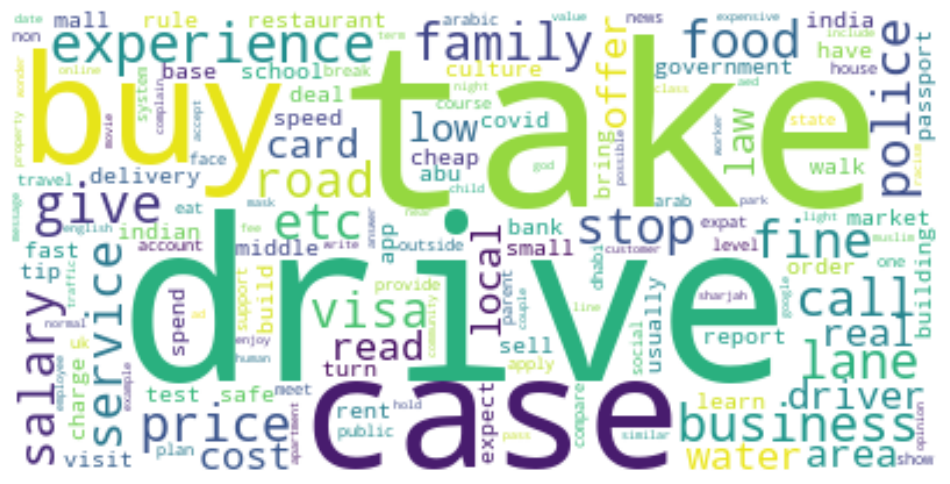

In [74]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(bow_features, X_bow.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

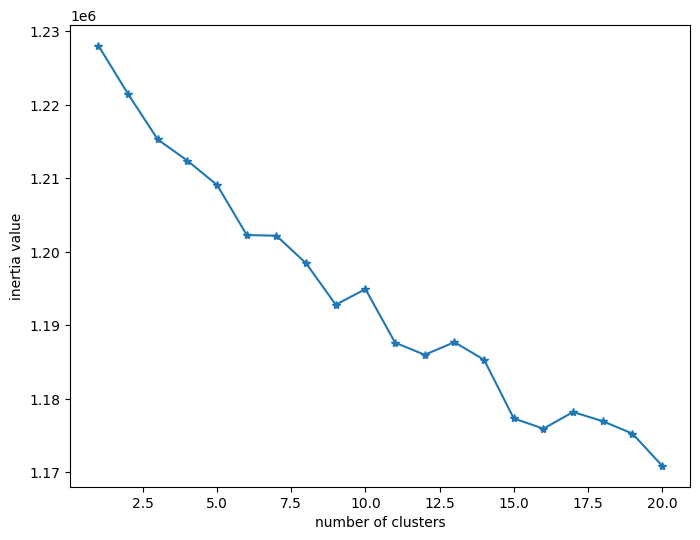

{'2 clusters': 0.5343771755109722, '3 clusters': 0.5262910436989094, '4 clusters': 0.5087707833170134, '5 clusters': 0.2976567186181362, '6 clusters': 0.3760842915094824, '7 clusters': 0.3392254201104237, '8 clusters': 0.2207951062960467, '9 clusters': 0.24042097858066688, '10 clusters': 0.27551453132717263, '11 clusters': 0.37520839730426536, '12 clusters': 0.3722812818983893, '13 clusters': 0.17303393997499028, '14 clusters': 0.22170940227374467, '15 clusters': 0.1832684361590613, '16 clusters': 0.207716789152269, '17 clusters': 0.3695577009074509, '18 clusters': 0.21131175400104277, '19 clusters': 0.1955351476175179, '20 clusters': 0.2007506513803016}


In [88]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,21))
sil_score = {}

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++',max_iter = 100, n_init = 10)#, batch_size = 500)
    kmeans.fit(X_bow)
    sse_metric.append(kmeans.inertia_)
    
    if k > 1:
        score = silhouette_score(X_bow, kmeans.labels_)
        sil_score.update({f'{k} clusters':score})
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

plt.show()
print (sil_score)
    

In [103]:
true_k = 4

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=10)

model.fit(X_bow)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = bow_features

i = 0
for cluster in order_centroids:
    print (f'cluster {i}')
    for keyword in cluster[:10]:
        print (terms[keyword])
    print ("")
    i+=1

cluster 0
take
case
buy
experience
give
food
price
call
etc
business

cluster 1
lane
drive
speed
road
fast
driver
limit
slow
overtake
traffic

cluster 2
fucking
focus
realize
language
important
emphasis
multiple
perfect
enjoy
internet

cluster 3
visa
property
police
market
case
business
aed
code
canada
buy



In [100]:
for cluster in order_centroids:
    for keyword in cluster:
        print (terms[keyword])
        break

take
drive
firm


In [97]:
order_centroids

array([[34316,  5017,  5133, ...,  3288, 33916, 11354],
       [10176,  5429, 19700, ..., 22498, 22499, 19763],
       [12753,  5198, 16944, ..., 26262, 26261,     0]])